<a href="https://colab.research.google.com/github/EvM82/Machine-Learning-25/blob/main/exercise7_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import re
from functools import partial
from collections import Counter
import nltk
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import GaussianNB

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Question 1- Load data and split train-test.

In [2]:
df=pd.read_csv("/content/train.csv")
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Split in train-test with ratio 90-10.

Create the x, y where y are the labels and x the corresponding feature values.

In [3]:
x = df.drop(columns=['target'])
y = df['target']

Split the dataset into training and test sets in a 90–10 ratio, using stratified sampling to mentain the class distribution and with random_state = 0 to ensure reproducibility.

In [4]:
x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=0.10, stratify=y, random_state=0)

print("Train set:", x_train.shape, y_train.shape)
print("Test set :", x_test.shape, y_test.shape)


Train set: (6851, 4) (6851,)
Test set : (762, 4) (762,)


Creation of bar-plots.

Count the appearances of each class in the dataset using value-counts and then based on the numbers create the bar plot.


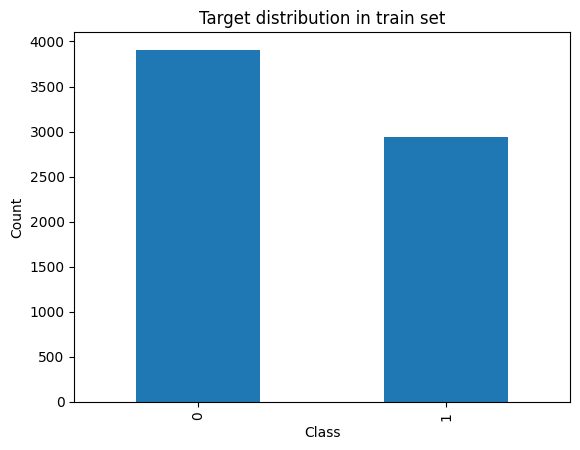

In [44]:
train_counts = y_train.value_counts()

plt.figure()
train_counts.plot(kind='bar')
plt.title("Target distribution in train set")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


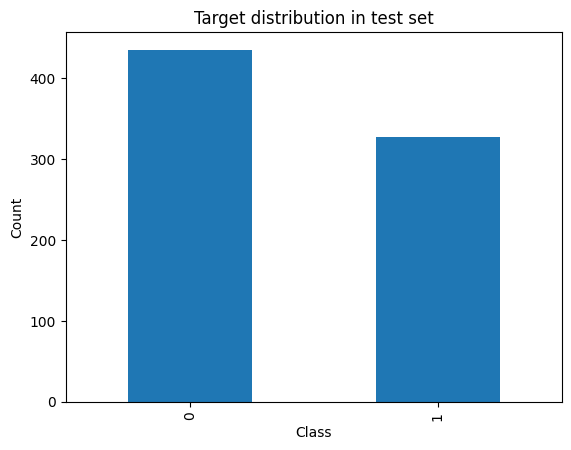

In [43]:
test_counts  = y_test.value_counts()

plt.figure()
test_counts.plot(kind='bar')
plt.title("Target distribution in test set")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

Both the training and test datasets appear to be balanced, with the class difference being approximately 1,000 samples in the training set and 100 samples in the test set.

## Question 2 - Processing of train/test.

a. Remove id, location columns.

In [7]:
x_train = x_train.drop(columns=['id', 'location'])
x_test = x_test.drop(columns=['id', 'location'])

b. Complete the empty values with the 'null' keyword.


In [8]:
x_train = x_train.fillna('null')
x_test = x_test.fillna('null')

c.Union of keyword and text column.
The code creates the column 'inputs' which is the combination of 'keyword' and 'text'.

In [9]:
x_train['inputs'] = x_train['keyword'].astype(str) + ' ' + x_train['text'].astype(str)
x_test['inputs'] = x_test['keyword'].astype(str) + ' ' + x_test['text'].astype(str)

In [10]:
print(x_train.columns)
print(x_test.columns)

Index(['keyword', 'text', 'inputs'], dtype='object')
Index(['keyword', 'text', 'inputs'], dtype='object')


## Question 3 -Remove not important information from text

Bellow are the functions from the given repository (https://github.com/Deffro/text-preprocessing-techniques/blob/master/techniques.py) that were used.

<br>
1. removeUnicode--> Unicode characters and symbols were removed as they do not provide discriminative information.
</br>
<br>
2. replaceURL-->URLs were replaced with a common token. The function is used beacause URLs appear in tweets but do not provide discriminative information for identifying natural disasters.
</br>
<br>
3. replaceAtUser--> User mentions were replaced with a generic token, since usernames do not provide any useful information.
</br>
<br>
4. removeHashtagInFrontOfWord--> The hashtag symbol is removed from the front of words, since it appears often in tweets but it is non-informative.
</br>
<br>
5. replaceElongated--> Elongated words are normalized to their base form (for example aaand-->and). The function is used because elongated words are commonly found in tweets.
</br>
<br>
6. removeEmoticons--> Emoticons were removed as they can convey ambiguous meanings and introduce noise in tweet classification.
</br>
<br>
7. addCapTag--> Words containing at least three uppercase characters are tagged. The function is used because capitalization can be used to indicate urgency or breaking information.
</br>
<br>
8. replaceMultiExclamationMark-->Repeated exclamation marks are replaced with a single token. The function is used because many exclamations often appear in various cases and keeping them is like keeping noise.
</br>
<br>
9. replaceMultiQuestionMark--> Repeated question marks are replaced with a single token for the same reason, reducing punctuation-related noise.
</br>
<br>
10. replaceMultiStopMark--> Repeated full stops are replaced with a single token, as multiple stop marks are frequently used without providing meaningful information.
</br>
<br>








In [11]:
#The preprocessing functions were directly copied from the repository provided in the exercise.
def removeUnicode(text):
    """ Removes unicode strings like "\u002c" and "x96" """
    text = re.sub(r'(\\u[0-9A-Fa-f]+)',r'', text)
    text = re.sub(r'[^\x00-\x7f]',r'',text)
    return text

def replaceURL(text):
    """ Replaces url address with "url" """
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','url',text)
    text = re.sub(r'#([^\s]+)', r'\1', text)
    return text

def replaceAtUser(text):
    """ Replaces "@user" with "atUser" """
    text = re.sub('@[^\s]+','atUser',text)
    return text

def removeHashtagInFrontOfWord(text):
    """ Removes hastag in front of a word """
    text = re.sub(r'#([^\s]+)', r'\1', text)
    return text

def replaceElongated(word):
    """ Replaces an elongated word with its basic form, unless the word exists in the lexicon """

    repeat_regexp = re.compile(r'(\w*)(\w)\2(\w*)')
    repl = r'\1\2\3'
    if wordnet.synsets(word):
        return word
    repl_word = repeat_regexp.sub(repl, word)
    if repl_word != word:
        return replaceElongated(repl_word)
    else:
        return repl_word

def removeEmoticons(text):
    """ Removes emoticons from text """
    text = re.sub(':\)|;\)|:-\)|\(-:|:-D|=D|:P|xD|X-p|\^\^|:-*|\^\.\^|\^\-\^|\^\_\^|\,-\)|\)-:|:\'\(|:\(|:-\(|:\S|T\.T|\.\_\.|:<|:-\S|:-<|\*\-\*|:O|=O|=\-O|O\.o|XO|O\_O|:-\@|=/|:/|X\-\(|>\.<|>=\(|D:', '', text)
    return text


def addCapTag(word):
    """ Finds a word with at least 3 characters capitalized and adds the tag ALL_CAPS_ """
    if(len(re.findall("[A-Z]{3,}", word))):
        word = word.replace('\\', '' )
        transformed = re.sub("[A-Z]{3,}", "ALL_CAPS_"+word, word)
        return transformed
    else:
        return word

def replaceMultiExclamationMark(text):
    """ Replaces repetitions of exlamation marks """
    text = re.sub(r"(\!)\1+", ' multiExclamation ', text)
    return text

def replaceMultiQuestionMark(text):
    """ Replaces repetitions of question marks """
    text = re.sub(r"(\?)\1+", ' multiQuestion ', text)
    return text

def replaceMultiStopMark(text):
    """ Replaces repetitions of stop marks """
    text = re.sub(r"(\.)\1+", ' multiStop ', text)
    return text


<>:10: SyntaxWarning: invalid escape sequence '\.'
<>:16: SyntaxWarning: invalid escape sequence '\s'
<>:39: SyntaxWarning: invalid escape sequence '\)'
<>:10: SyntaxWarning: invalid escape sequence '\.'
<>:16: SyntaxWarning: invalid escape sequence '\s'
<>:39: SyntaxWarning: invalid escape sequence '\)'
/tmp/ipython-input-1734257727.py:10: SyntaxWarning: invalid escape sequence '\.'
  text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','url',text)
/tmp/ipython-input-1734257727.py:16: SyntaxWarning: invalid escape sequence '\s'
  text = re.sub('@[^\s]+','atUser',text)
/tmp/ipython-input-1734257727.py:39: SyntaxWarning: invalid escape sequence '\)'
  text = re.sub(':\)|;\)|:-\)|\(-:|:-D|=D|:P|xD|X-p|\^\^|:-*|\^\.\^|\^\-\^|\^\_\^|\,-\)|\)-:|:\'\(|:\(|:-\(|:\S|T\.T|\.\_\.|:<|:-\S|:-<|\*\-\*|:O|=O|=\-O|O\.o|XO|O\_O|:-\@|=/|:/|X\-\(|>\.<|>=\(|D:', '', text)


Since the addCapTag and replaceElongated functions operate at word level, the functions apply_cap_tag_to_text and apply_replace_elongated_to_text were added to apply these transformations to the entire text by tokenizing it and processing each word individually.

In [12]:
def apply_cap_tag_to_text(text):
    return " ".join(addCapTag(w) for w in str(text).split())

def apply_replace_elongated_to_text(text):
    return " ".join(replaceElongated(w) for w in str(text).split())


The function clean_post applies the functions mentioned above to a given text. Finally, the letters are converted to lowercase in order to reduce vocabulary size.


In [13]:
def clean_post(text):
    text = removeUnicode(text)
    text = replaceURL(text)
    text = replaceAtUser(text)
    text = removeHashtagInFrontOfWord(text)
    text = removeEmoticons(text)

    text = replaceMultiExclamationMark(text)
    text = replaceMultiQuestionMark(text)
    text = replaceMultiStopMark(text)

    text = apply_cap_tag_to_text(text)
    text = apply_replace_elongated_to_text(text)

    text = text.lower()

    text = re.sub(r"\s+", " ", text).strip()
    return text


In [14]:
txt_train = x_train['inputs'].apply(clean_post)
txt_test  = x_test['inputs'].apply(clean_post)

## Question 4 - transform to numpy arrays

In [16]:
x_train_np = txt_train.to_numpy()
x_test_np  = txt_test.to_numpy()

y_train_np = y_train.to_numpy()
y_test_np  = y_test.to_numpy()


## Question 5 - tf-idf

In [19]:
tfidf = TfidfVectorizer( )

x_train_tfidf = tfidf.fit_transform(x_train_np)
x_test_tfidf  = tfidf.transform(x_test_np)

print(x_train_tfidf.shape)
print(x_test_tfidf.shape)

(6851, 15371)
(762, 15371)


## Question 6 -SVM

In [30]:
svm_clf = LinearSVC(random_state=0)
svm_clf.fit(x_train_tfidf, y_train)

y_train_pred = svm_clf.predict(x_train_tfidf)

acc = accuracy_score(y_train, y_train_pred)
prec = precision_score(y_train, y_train_pred)
rec  = recall_score(y_train, y_train_pred)
f1   = f1_score(y_train, y_train_pred)
print("Metrics in train:")
print(f"  Accuracy : {acc:.4f}")
print(f"  Precision: {prec:.4f}")
print(f"  Recall   : {rec:.4f}")
print(f"  F1-score : {f1:.4f}\n")


y_test_pred  = svm_clf.predict(x_test_tfidf)

acc1  = accuracy_score(y_test, y_test_pred)
prec1 = precision_score(y_test, y_test_pred)
rec1  = recall_score(y_test, y_test_pred)
f11   = f1_score(y_test, y_test_pred)
print("Metrics in test:")
print(f"  Accuracy : {acc1:.4f}")
print(f"  Precision: {prec1:.4f}")
print(f"  Recall   : {rec1:.4f}")
print(f"  F1-score : {f11:.4f}")


Metrics in train:
  Accuracy : 0.9666
  Precision: 0.9782
  Recall   : 0.9433
  F1-score : 0.9604

Metrics in test:
  Accuracy : 0.8084
  Precision: 0.8007
  Recall   : 0.7370
  F1-score : 0.7675


It is observed that there is no significant performance difference between the training and test sets, indicating that there isn't overfitting and the model can discriminate between classes based on the available features.
<br>
In this application, the F1-score is the most informative metric, because it balances precision and recall, showing both the detection of real disasters and the reliability of positive predictions.

## Question 7-PCA and RBF kernel

In order to apply PCA to TF-IDF data, the TruncatedSVD method is used, which represents the PCA for sparse data representations (such as TF-IDF data).
<br>
Initially, the minimum number of components that preserve 95% of the original information is computed, and then the PCA transformation is applied based on these components.
<br>
This procedure differs from classical PCA function, which directly accepts the percentage of the information that is to be preserved as a parameter and automatically computes the required number of components.

In [23]:
svd_tmp = TruncatedSVD(n_components=min(300, x_train_tfidf.shape[1]),random_state=0)
svd_tmp.fit(x_train_tfidf)

explained_variance = np.cumsum(svd_tmp.explained_variance_ratio_)
n_components_95 = np.searchsorted(explained_variance, 0.95) + 1

print("Number of components:", n_components_95)


Number of components: 301


Applying the pca for the components that preserve 95% of the original information in train and test data. From the original 15371 dimensions, only the 300 are used to keep the 95% ofthe information, which means that the dimensionality after PCA has been decreasded by a lot without severe information loss.

In [24]:
svd = TruncatedSVD(n_components=n_components_95, random_state=0)

x_train_pca = svd.fit_transform(x_train_tfidf)
x_test_pca  = svd.transform(x_test_tfidf)

print(x_train_pca.shape)
print(x_test_pca.shape)


(6851, 301)
(762, 301)


Linear svc

In [31]:
lin = LinearSVC(random_state=0)
lin.fit(x_train_pca, y_train)

y_train_pred = lin.predict(x_train_pca)

acc  = accuracy_score(y_train, y_train_pred)
prec = precision_score(y_train, y_train_pred)
rec  = recall_score(y_train, y_train_pred)
f1   = f1_score(y_train, y_train_pred)
print("Metrics in train:")
print(f"  Accuracy : {acc:.4f}")
print(f"  Precision: {prec:.4f}")
print(f"  Recall   : {rec:.4f}")
print(f"  F1-score : {f1:.4f}\n")


y_test_pred = lin.predict(x_test_pca)

acc2  = accuracy_score(y_test, y_test_pred)
prec2 = precision_score(y_test, y_test_pred)
rec2  = recall_score(y_test, y_test_pred)
f12   = f1_score(y_test, y_test_pred)
print("Metrics in test:")
print(f"  Accuracy : {acc2:.4f}")
print(f"  Precision: {prec2:.4f}")
print(f"  Recall   : {rec2:.4f}")
print(f"  F1-score : {f12:.4f}")

Metrics in train:
  Accuracy : 0.8048
  Precision: 0.8024
  Recall   : 0.7242
  F1-score : 0.7613

Metrics in test:
  Accuracy : 0.7953
  Precision: 0.7860
  Recall   : 0.7187
  F1-score : 0.7508


svc rbf kernel

In [32]:
rbf = SVC(kernel="rbf", C=1.0, gamma="scale", random_state=0)
rbf.fit(x_train_pca, y_train)

y_train_pred = rbf.predict(x_train_pca)
acc  = accuracy_score(y_train, y_train_pred)
prec = precision_score(y_train, y_train_pred)
rec  = recall_score(y_train, y_train_pred)
f1   = f1_score(y_train, y_train_pred)
print("Metrics in train:")
print(f"  Accuracy : {acc:.4f}")
print(f"  Precision: {prec:.4f}")
print(f"  Recall   : {rec:.4f}")
print(f"  F1-score : {f1:.4f}\n")


y_test_pred  = rbf.predict(x_test_pca)

acc3  = accuracy_score(y_test, y_test_pred)
prec3 = precision_score(y_test, y_test_pred)
rec3  = recall_score(y_test, y_test_pred)
f13   = f1_score(y_test, y_test_pred)
print("Metrics in test:")
print(f"  Accuracy : {acc3:.4f}")
print(f"  Precision: {prec3:.4f}")
print(f"  Recall   : {rec3:.4f}")
print(f"  F1-score : {f13:.4f}")

Metrics in train:
  Accuracy : 0.8597
  Precision: 0.8924
  Recall   : 0.7660
  F1-score : 0.8243

Metrics in test:
  Accuracy : 0.7966
  Precision: 0.8071
  Recall   : 0.6911
  F1-score : 0.7446


The performance of the Linear SVC and the RBF SVC is relatively similar.
<br>
The linear model achieves higher recall, while the RBF kernel attains better precision and slightly higher accuracy. The F1-score is slightly higher for the linear model, with a small difference between the two classifiers.
<br>
 Additionally, for both SVC models, the performance gap between the training and test sets is not substantial, indicating reasonable generalization.

## Question 8

In [34]:
rbf = SVC(kernel="rbf", C=1.0, gamma="auto", random_state=0)
rbf.fit(x_train_pca, y_train)

y_train_pred = rbf.predict(x_train_pca)
acc  = accuracy_score(y_train, y_train_pred)
prec = precision_score(y_train, y_train_pred)
rec  = recall_score(y_train, y_train_pred)
f1   = f1_score(y_train, y_train_pred)

print("Metrics in train:")
print(f"  Accuracy : {acc:.4f}")
print(f"  Precision: {prec:.4f}")
print(f"  Recall   : {rec:.4f}")
print(f"  F1-score : {f1:.4f}\n")

y_test_pred = rbf.predict(x_test_pca)

acc4  = accuracy_score(y_test, y_test_pred)
prec4 = precision_score(y_test, y_test_pred)
rec4  = recall_score(y_test, y_test_pred)
f14   = f1_score(y_test, y_test_pred)

print("Metrics in test:")
print(f"  Accuracy : {acc4:.4f}")
print(f"  Precision: {prec4:.4f}")
print(f"  Recall   : {rec4:.4f}")
print(f"  F1-score : {f14:.4f}")

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Metrics in train:
  Accuracy : 0.5703
  Precision: 0.0000
  Recall   : 0.0000
  F1-score : 0.0000

Metrics in test:
  Accuracy : 0.5709
  Precision: 0.0000
  Recall   : 0.0000
  F1-score : 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


When using the default γ, the RBF SVC adapts to both the feature dimensionality and the data variance.  

**Default value:** <br>

$$
\gamma = \frac{1}{n_{\text{features}} \cdot \mathrm{Var}(X)}
$$
</br>
<br>
In contrast, auto γ, depends only on the number of features, which may lead to less optimal decision boundaries.  
**Auto value:** <br>
$$
\gamma = \frac{1}{n_{\text{features}}}
$$
</br>
<br>
As a result, the performance with γ was significantly inferior, yielding zero values for all metrics except for accuracy. This confirms that the default γ setting is more suitable for this dataset.


Bellow the are are the bar plots of the metrics for the 4 models.
4 arrays are created, each contains the metrics of the 4 models

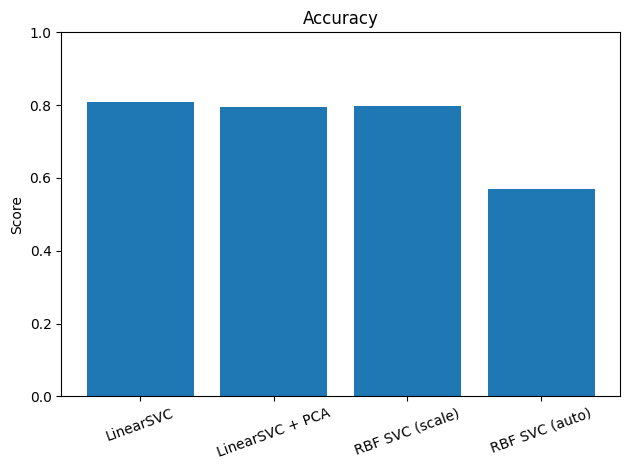

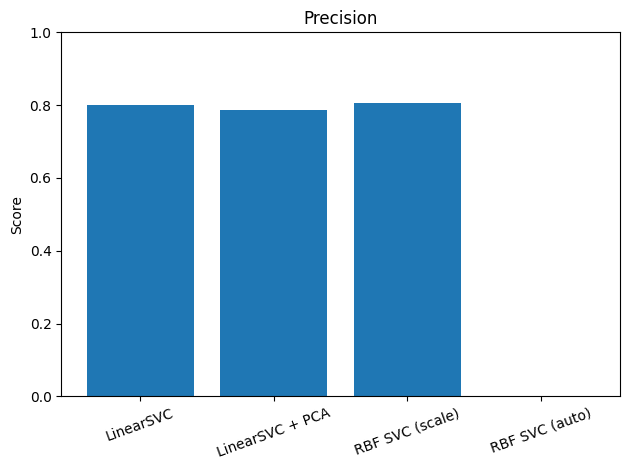

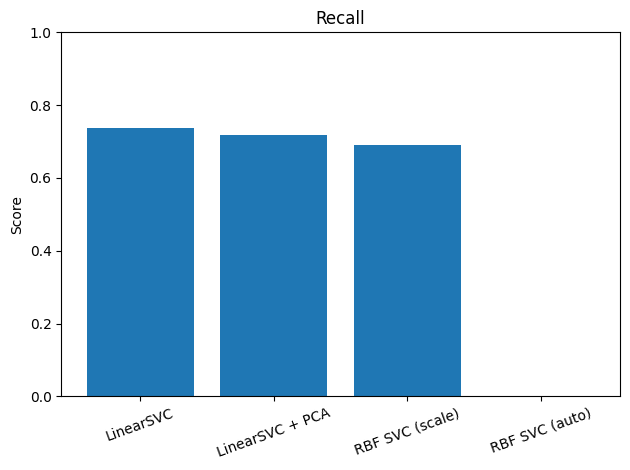

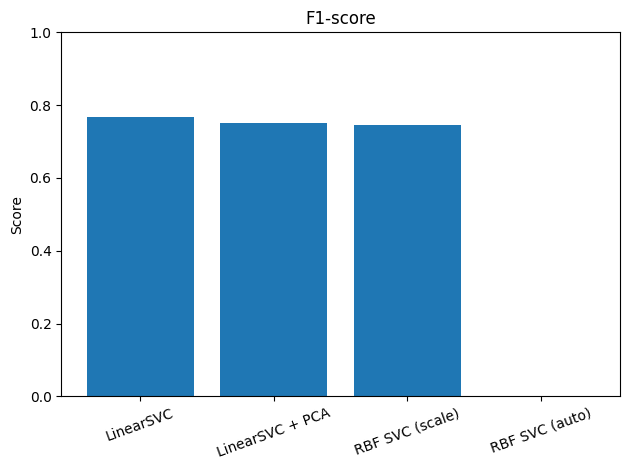

In [39]:
models = ["LinearSVC","LinearSVC + PCA","RBF SVC (scale)","RBF SVC (auto)"]

accuracy  = [acc1, acc2, acc3, acc4]
precision = [prec1, prec2, prec3, prec4]
recall    = [rec1, rec2, rec3, rec4]
f1        = [f11, f12, f13, f14]

metrics = {
    "Accuracy":  accuracy,
    "Precision": precision,
    "Recall":    recall,
    "F1-score":  f1
}

for metric_name, values in metrics.items():
    plt.bar(models, values)
    plt.title(metric_name)
    plt.ylabel("Score")
    plt.xticks(rotation=20)
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

We observe that there aren't maney variations in the metric values across the models, with the exception being the RBF SVC using γ="auto", for which the accuracy is lower than the rest and the remaining metrics drop to zero.

## Question 9

In order to apply Gaussian Naive Bayes, the TF-IDF features must be converted to NumPy arrays before being passed to the model.

In [41]:
x_train_b = x_train_tfidf.toarray()
x_test_b  = x_test_tfidf.toarray()


In [42]:
gnb = GaussianNB()
gnb.fit(x_train_b, y_train)


y_train_pred = gnb.predict(x_train_b)
acc  = accuracy_score(y_train, y_train_pred)
prec = precision_score(y_train, y_train_pred)
rec  = recall_score(y_train, y_train_pred)
f1   = f1_score(y_train, y_train_pred)

print("Metrics in train:")
print(f"  Accuracy : {acc:.4f}")
print(f"  Precision: {prec:.4f}")
print(f"  Recall   : {rec:.4f}")
print(f"  F1-score : {f1:.4f}\n")


y_test_pred  = gnb.predict(x_test_b)

acc4  = accuracy_score(y_test, y_test_pred)
prec4 = precision_score(y_test, y_test_pred)
rec4  = recall_score(y_test, y_test_pred)
f14   = f1_score(y_test, y_test_pred)

print("Metrics in test:")
print(f"  Accuracy : {acc4:.4f}")
print(f"  Precision: {prec4:.4f}")
print(f"  Recall   : {rec4:.4f}")
print(f"  F1-score : {f14:.4f}")

Metrics in train:
  Accuracy : 0.8953
  Precision: 0.8042
  Recall   : 1.0000
  F1-score : 0.8914

Metrics in test:
  Accuracy : 0.6325
  Precision: 0.5508
  Recall   : 0.7798
  F1-score : 0.6456


It is observed that the performance of the Gaussian Naive Bayes classifier is close to that of the previously models. Also, there is no significant performance gap between the training and test sets, indicating stable generalization and no overfitting.